In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_energy = pd.read_csv('ENB2012_data.csv')

df_energy.head()


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [49]:
# Imports

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import warnings
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")
RANDOM_STATE = 10

In [50]:
# Divisão treino / teste
# 70% treino / 30% teste

X = df_energy.drop(['Y1'], axis=1)  
y = df_energy['Y1']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
    # test_size=0.3 indica que 30% dos dados vão para teste, e o restante (70%) para treino.
)

def avaliar_modelo(nome, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nModelo: {nome}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    return {'Modelo': nome, 'RMSE': rmse, 'MAE': mae, 'R2': r2}


In [51]:
# Padronização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

### Pré-processamento dos Dados

Para este experimento, foi aplicada a **padronização (z-score normalization)** aos atributos de entrada para os modelos lineares (**Regressão Linear** e **Ridge Regression**). 

A padronização transforma os dados para que tenham média 0 e desvio padrão 1, o que é essencial para modelos que são sensíveis à escala dos atributos. 

Modelos baseados em árvores, como **Árvore de Decisão** e **Random Forest**, não exigem essa transformação, pois são invariantes à escala.

A transformação foi aplicada apenas aos dados de treino, e depois replicada nos dados de teste para evitar vazamento de informação.


In [52]:
# COM HIPERPARAMETROS

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_svr = {
    'C': uniform(1, 1000),
    'epsilon': uniform(0.01, 1.0),
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

rand_svr = RandomizedSearchCV(SVR(), param_svr, n_iter=50, cv=5, 
                              scoring='neg_root_mean_squared_error', random_state=42)
rand_svr.fit(X_train_scaled, y_train)

best_svr = rand_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)
res_svr = avaliar_modelo("SVR (Melhor com RandomSearch)", y_test, y_pred_svr)



Modelo: SVR (Melhor com RandomSearch)
RMSE: 0.5540
MAE: 0.3684
R²: 0.9970


In [53]:
from scipy.stats import loguniform

param_ridge = {
    'alpha': loguniform(0.001, 1000)
}

rand_ridge = RandomizedSearchCV(Ridge(), param_ridge, n_iter=50, cv=5,
                                scoring='neg_root_mean_squared_error', random_state=42)
rand_ridge.fit(X_train_scaled, y_train)

best_ridge = rand_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)
res_ridge = avaliar_modelo("Ridge Regression (Melhor com RandomSearch)", y_test, y_pred_ridge)



Modelo: Ridge Regression (Melhor com RandomSearch)
RMSE: 1.8350
MAE: 1.2553
R²: 0.9670


In [54]:
param_tree = {
    'max_depth': [None] + list(range(5, 51, 5)),
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 10]
}

rand_tree = RandomizedSearchCV(DecisionTreeRegressor(random_state=42), param_tree, 
                               n_iter=50, cv=5, scoring='neg_root_mean_squared_error', random_state=42)
rand_tree.fit(X_train, y_train)

best_tree = rand_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test)
res_tree = avaliar_modelo("Árvore de Decisão (Melhor com RandomSearch)", y_test, y_pred_tree)



Modelo: Árvore de Decisão (Melhor com RandomSearch)
RMSE: 1.1250
MAE: 0.4810
R²: 0.9876


In [55]:
param_rf = {
    'n_estimators': [100, 200, 300, 500, 800],
    'max_depth': [None] + list(range(10, 61, 10)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rand_rf = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_rf, 
                             n_iter=50, cv=5, scoring='neg_root_mean_squared_error', random_state=42)
rand_rf.fit(X_train, y_train)

best_rf = rand_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
res_rf = avaliar_modelo("Random Forest (Melhor com RandomSearch)", y_test, y_pred_rf)



Modelo: Random Forest (Melhor com RandomSearch)
RMSE: 0.7125
MAE: 0.4194
R²: 0.9950


In [56]:
resultados = pd.DataFrame([res_svr, res_ridge, res_tree, res_rf])
resultados.sort_values("RMSE")


,Modelo,RMSE,MAE,R2
0,SVR (Melhor com RandomSearch),0.553974,0.368438,0.996992
3,Random Forest (Melhor com RandomSearch),0.712527,0.419419,0.995024
2,Árvore de Decisão (Melhor com RandomSearch),1.125033,0.480996,0.987595
1,Ridge Regression (Melhor com RandomSearch),1.834984,1.255310,0.966999


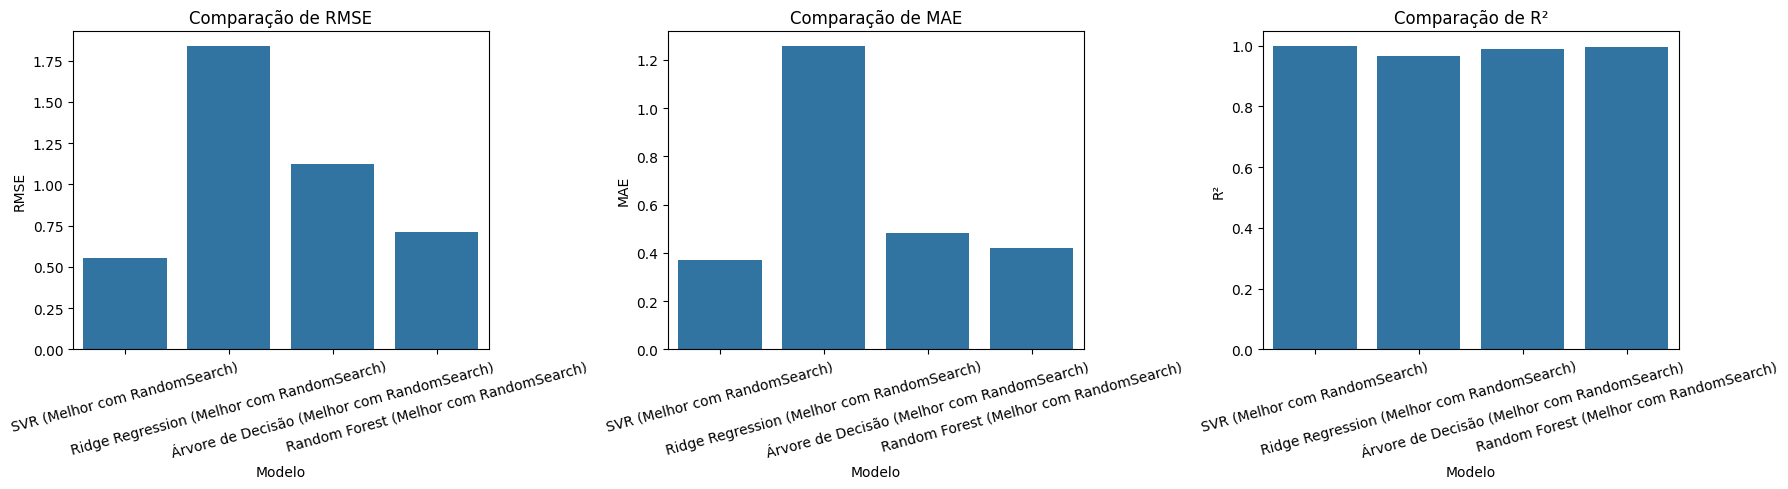

In [57]:
# Gráfico de barras para RMSE, MAE, R²
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
sns.barplot(x="Modelo", y="RMSE", data=resultados, ax=axs[0])
axs[0].set_title("Comparação de RMSE")
axs[0].set_ylabel("RMSE")
axs[0].tick_params(axis='x', rotation=15)

# MAE
sns.barplot(x="Modelo", y="MAE", data=resultados, ax=axs[1])
axs[1].set_title("Comparação de MAE")
axs[1].set_ylabel("MAE")
axs[1].tick_params(axis='x', rotation=15)

# R²
sns.barplot(x="Modelo", y="R2", data=resultados, ax=axs[2])
axs[2].set_title("Comparação de R²")
axs[2].set_ylabel("R²")
axs[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()


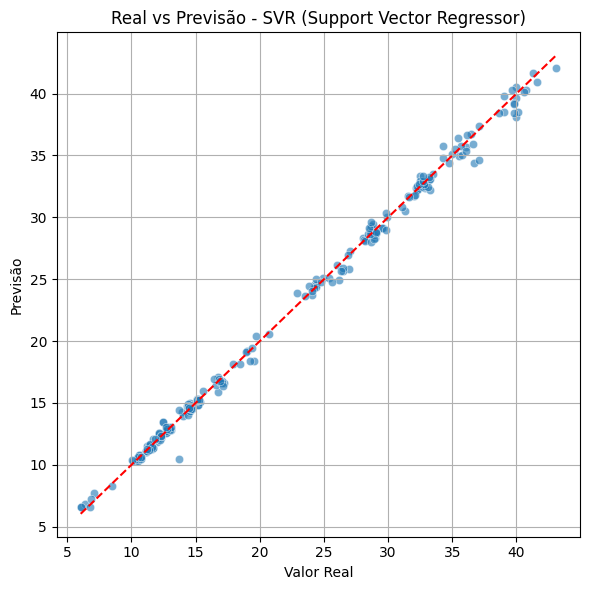

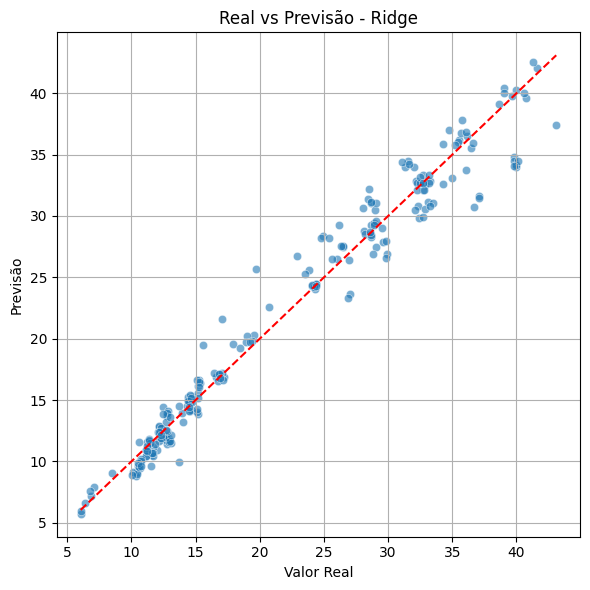

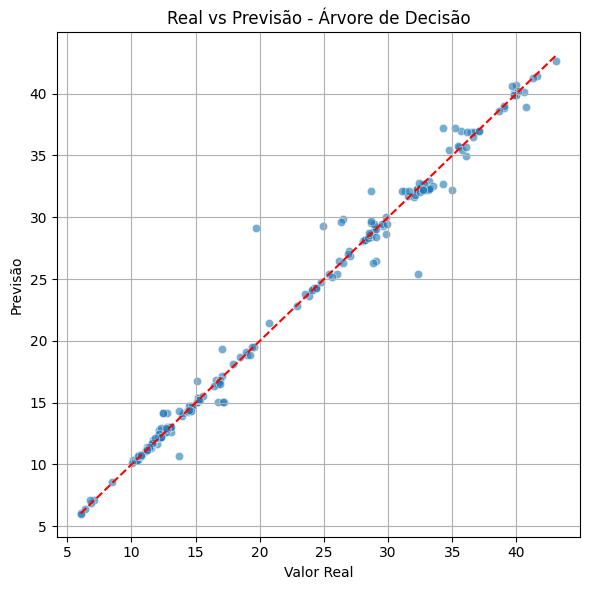

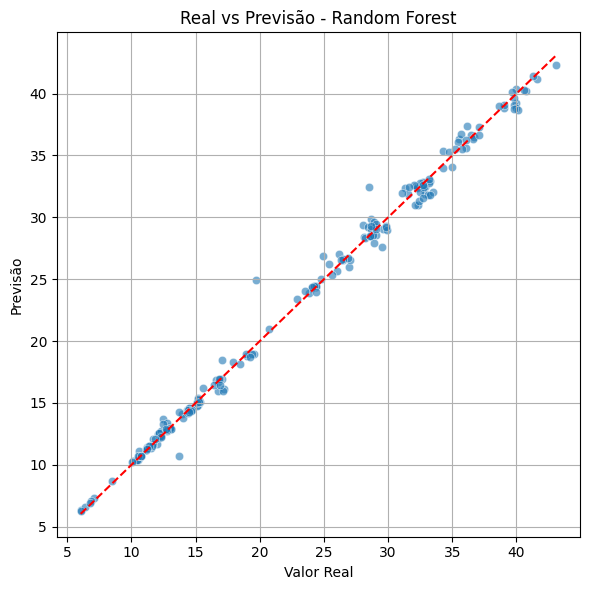

In [58]:
def plot_predicoes(y_true, y_pred, nome_modelo):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Valor Real")
    plt.ylabel("Previsão")
    plt.title(f"Real vs Previsão - {nome_modelo}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Gerando gráficos para cada modelo
plot_predicoes(y_test, y_pred_svr, "SVR (Support Vector Regressor)")
plot_predicoes(y_test, y_pred_ridge, "Ridge")
plot_predicoes(y_test, y_pred_tree, "Árvore de Decisão")
plot_predicoes(y_test, y_pred_rf, "Random Forest")


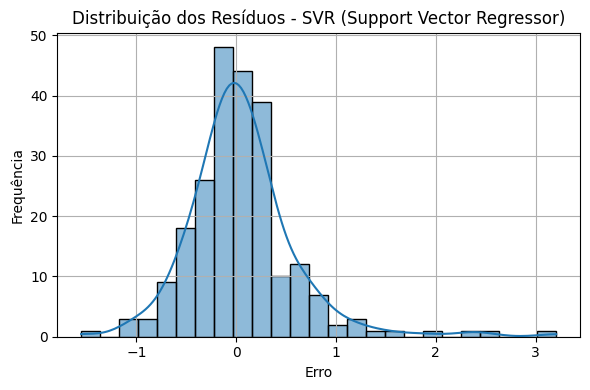

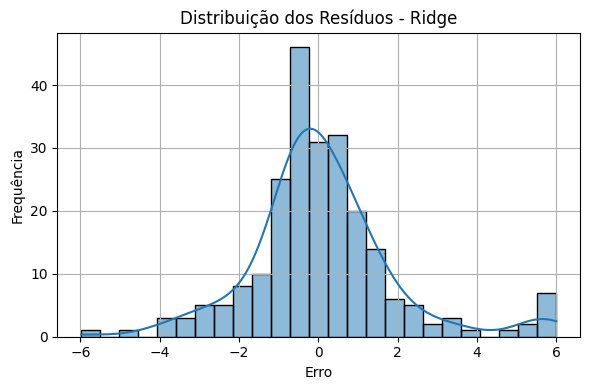

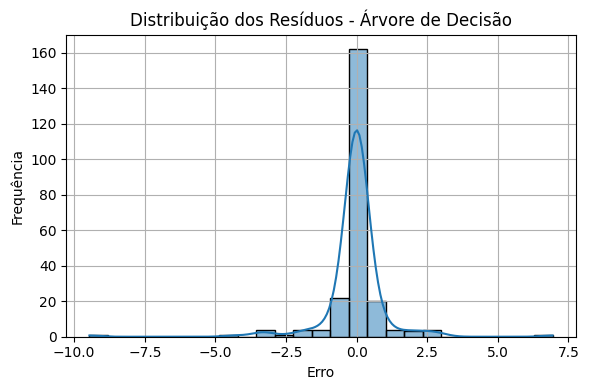

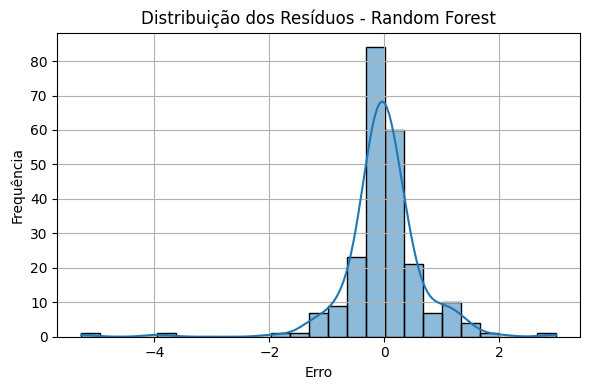

In [59]:
def plot_residuos(y_true, y_pred, nome_modelo):
    erros = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(erros, kde=True, bins=25)
    plt.title(f"Distribuição dos Resíduos - {nome_modelo}")
    plt.xlabel("Erro")
    plt.ylabel("Frequência")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_residuos(y_test, y_pred_svr, "SVR (Support Vector Regressor)")
plot_residuos(y_test, y_pred_ridge, "Ridge")
plot_residuos(y_test, y_pred_tree, "Árvore de Decisão")
plot_residuos(y_test, y_pred_rf, "Random Forest")

